<a href="https://colab.research.google.com/github/GreggRodgers02/Colab_notebooks/blob/main/Elevator_Pitch_Career_Fair_Planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

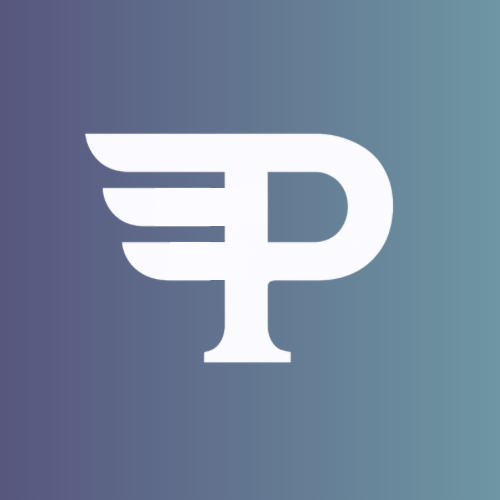
# Elevator Pitch: Career Fair Planner

## Setup

In [ ]:
# !pip install -U langchain
# !pip install -U langchain-openai
# !pip install -U langchain-core
# !pip install -U langchain-community

In [ ]:
#Imported Libraries and Dependencies
from langchain_openai import OpenAI, ChatOpenAI
from langchain.agents import create_agent
import os
from getpass import getpass
import json
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatMessagePromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

In [ ]:
# Update this dictionary to experiments with different inputs to the API
career_fair_planner_input = {
    "experience": [
        {
            "company_label": "A",
            "company_name": "Google",
            "company_position": "Software Engineering Intern",
            "years_of_experience": 1,
            "key_talking_points": [
                "Built backend APIs in Python and Flask",
                "Worked with large-scale data pipelines",
                "Collaborated with cross-functional teams",
                "Improved system performance by 20%",
                "Used Git and code reviews daily",
                "Learned best practices for production systems"
            ]
        },
        {
            "company_label": "B",
            "company_name": "Amazon",
            "company_position": "SDE Intern",
            "years_of_experience": 1,
            "key_talking_points": [
                "Developed microservices in Java",
                "Worked with AWS services like DynamoDB and S3",
                "Followed Agile development practices",
                "Wrote unit and integration tests",
                "Participated in sprint planning",
                "Focused on scalable system design"
            ]
        },
        {
            "company_label": "C",
            "company_name": "Startup XYZ",
            "company_position": "Full Stack Developer",
            "years_of_experience": 2,
            "key_talking_points": [
                "Built React frontend components",
                "Designed REST APIs",
                "Owned features end-to-end",
                "Worked closely with founders",
                "Deployed applications to the cloud",
                "Handled rapid iteration and feedback"
            ]
        },
        {
            "company_label": "D",
            "company_name": "University Research Lab",
            "company_position": "Research Assistant",
            "years_of_experience": 1,
            "key_talking_points": [
                "Conducted machine learning experiments",
                "Worked with PyTorch",
                "Analyzed experimental results",
                "Read and summarized academic papers",
                "Presented findings to faculty",
                "Improved model accuracy by tuning hyperparameters"
            ]
        },
        {
            "company_label": "E",
            "company_name": "Freelance",
            "company_position": "Software Consultant",
            "years_of_experience": 1,
            "key_talking_points": [
                "Built custom tools for small businesses",
                "Gathered requirements from clients",
                "Delivered projects on tight deadlines",
                "Maintained client communication",
                "Used Python and JavaScript",
                "Focused on user experience"
            ]
        }
    ],

    "top_skills": [
        "Python",
        "Machine Learning",
        "Full Stack Development"
    ],

    "proudest_projects": [
        "AI-powered resume analyzer",
        "Career fair networking assistant"
    ],

    "career_fair_name": "Tech Innovators Career Fair 2025",

    "targets": [
        {
            "target_label": "X",
            "target_company": "OpenAI",
            "targeted_position": "AI Engineer",
            "targeted_position_description": "Build and deploy machine learning models for real-world applications"
        },
        {
            "target_label": "Y",
            "target_company": "Meta",
            "targeted_position": "Software Engineer",
            "targeted_position_description": "Develop scalable systems for social platforms"
        },
        {
            "target_label": "Z",
            "target_company": "NVIDIA",
            "targeted_position": "Machine Learning Engineer",
            "targeted_position_description": "Optimize deep learning models for GPU acceleration"
        }
    ]
}


In [ ]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API Key")

model = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0)

agent = create_agent(model)

#Input API Key Bellow

## Chain One

In [ ]:
#Constructing the prompts (System and User)

EP_input_json = json.dumps(career_fair_planner_input, indent=2)
system_prompt = SystemMessagePromptTemplate.from_template(
    '''
You are a careful career-coach assistant that SELECTS EVIDENCE BULLETS.
You must ONLY use facts explicitly present in the provided JSON.
Do NOT invent metrics, tools, employers, timelines, or achievements.
Each selected bullet MUST include a source_path pointing to the exact field used.
Return ONLY valid JSON that matches the provided JSON Schema.
    '''
)
user_prompt = HumanMessagePromptTemplate.from_template(
    '''
INPUT JSON:
{EP_input_json}

Select evidence bullets for:
- company_label: {company_label}
- target_label: {target_label}

Rules:
1) Use only the specified company experience entry and optionally top_skills / proudest_projects / the specified target description.
2) Choose 3–6 bullets that best match the target role needs.
3) Each bullet must be 1 sentence, specific, and grounded.
4) Every bullet must include a source_path like:
   experience[0].key_talking_points[3]
   top_skills[1]
   proudest_projects[0]
   targets[2].targeted_position_description

Output JSON fields:
company_label, target_label, company_name, experience_index, target_index, selected_bullets
    '''
)



In [ ]:
# Merging the prompts together
first_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

In [ ]:
chain_one = (
    first_prompt
    | model
)

In [ ]:
company_a_msg = chain_one.invoke({
    "EP_input_json": EP_input_json,
    "company_label": "A",
    "target_label": "X"
})
company_b_msg = chain_one.invoke({
    "EP_input_json": EP_input_json,
    "company_label": "B",
    "target_label": "Y"
})
company_c_msg = chain_one.invoke({
    "EP_input_json": EP_input_json,
    "company_label": "C",
    "target_label": "Z"
})

company_a = json.loads(company_a_msg.content)
company_b = json.loads(company_b_msg.content)
company_c = json.loads(company_c_msg.content)

chain_one_output = {
    "companies": [
        company_a,
        company_b,
        company_c
    ]
}

print(json.dumps(chain_one_output, indent=2))


## Chain Two

In [ ]:
second_system_prompt = SystemMessagePromptTemplate.from_template(
    '''
You are an AI Career Fair Coach. You write concise, high-impact networking content for career fairs.

You will be given:
- evidence selected from the user's background (talking points + skills)
- target company/role context

Your job:
1) For EACH company result provided, produce:
   - company_label
   - company_name
   - a tailored elevator pitch (45–75 seconds spoken length; 90–160 words)
   - a tailored follow-up message (email/LinkedIn style; 80–140 words)
2) Produce ONE career fair strategy summary (120–220 words) that covers:
   - how to approach the booth
   - how to open the conversation
   - how to steer toward the targeted role
   - how to close + ask for next steps

Hard requirements:
- Return ONLY valid JSON (no markdown, no backticks, no extra commentary).
- Use ONLY the evidence provided. Do not invent experiences, metrics, employers, or skills not included.
- When referencing evidence, weave it naturally into prose; do not mention "source_path" or "evidence".
- Make content specific to the targeted role description when available.
- Tone: confident, friendly, professional, not overly formal.
    '''
)
second_user_prompt = HumanMessagePromptTemplate.from_template(
    '''
Using the Chain 1 results below, generate the required JSON output.

Chain 1 Results (JSON):
{chain_one_output}

Instructions:
- For each company object, infer company_name from the selected evidence when present.
  - If company_name is not explicitly available, set company_name to "Unknown" and still write the pitch/message using the bullets provided.
- Elevator pitch must be directly useful for speaking to a recruiter at a booth.
- Follow-up message must be ready to send after the career fair (include a short subject line inside the message text).
- Career fair strategy summary should be actionable and concise.

Return JSON in exactly this structure:
{{
  "companies": [
    {{
      "company_label": "A",
      "company_name": "string",
      "elevator_pitch": "string",
      "follow_up_message": "string"
    }},
    {{
      "company_label": "B",
      "company_name": "string",
      "elevator_pitch": "string",
      "follow_up_message": "string"
    }},
    {{
      "company_label": "C",
      "company_name": "string",
      "elevator_pitch": "string",
      "follow_up_message": "string"
    }}
  ],
  "career_fair_strategy_summary": "string"
}}
    '''
)

In [ ]:
second_prompt = ChatPromptTemplate.from_messages([second_system_prompt, second_user_prompt])

In [ ]:
chain_two = (
    second_prompt
    | model
)

In [ ]:
chain_two_output = chain_two.invoke({
    "chain_one_output": json.dumps(chain_one_output, indent=2)
})
print(json.dumps(json.loads(chain_two_output.content), indent=2))

## Chain 3

In [ ]:
judge_system = SystemMessagePromptTemplate.from_template(
    '''
You are a strict evaluator (judge) for career fair elevator pitches and follow-up messages.

You will be given:
- The user's evidence (from profile / Chain 1 selections)
- Draft outputs (from Chain 2)

Evaluate each pitch + follow-up against the rubric and return ONLY valid JSON.

Rubric (must evaluate each target/pitch):
1) Under 30 seconds (aim <= ~160 words for the elevator pitch)
2) Mentions role + company naturally
3) Includes a concrete example from the user profile evidence
4) Avoids invented metrics or claims not supported by evidence
5) Follow-up message is specific and polite

Hard rules:
- Return ONLY JSON (no markdown).
- Do not rewrite content; only evaluate and propose fixes.
- If evidence is insufficient for a requirement, mark fail and explain what to change.
    '''
)

# Define the JSON schema string with all internal curly braces double-escaped
judge_output_schema = '''
{{
  "overall_pass": boolean,
  "rubric": {{
    "under_30_seconds": {{"pass": boolean, "notes": "string"}},
    "mentions_role_and_company_naturally": {{"pass": boolean, "notes": "string"}},
    "concrete_example_from_profile": {{"pass": boolean, "notes": "string"}},
    "avoids_invented_metrics": {{"pass": boolean, "notes": "string"}},
    "follow_up_specific_and_polite": {{"pass": boolean, "notes": "string"}}
  }},
  "fixes": ["string", "string"]
}}
'''

judge_user = HumanMessagePromptTemplate.from_template(
    f'''
Evaluate the draft content below using the rubric.

EVIDENCE (JSON):
{{chain_one_output}}

DRAFT (JSON):
{{chain_two_output}}

Return JSON in this structure:
{judge_output_schema}

Notes:
- Judge “under 30 seconds” by word count: <= 75 words is a pass.
- Focus on actionable fixes that a reviser can apply.
    '''
)


In [ ]:
judge_prompt = ChatPromptTemplate.from_messages([judge_system, judge_user])

In [ ]:
chain_three = (
    judge_prompt
    | model
)

In [ ]:
chain_three_output = chain_three.invoke({
    "chain_one_output": json.dumps(chain_one_output, indent=2),
    "chain_two_output": json.dumps(json.loads(chain_two_output.content), indent=2)
})
print(json.dumps(json.loads(chain_three_output.content), indent=2))

## Chain 4

In [ ]:
reviser_system = SystemMessagePromptTemplate.from_template(
    '''
You are a career fair content editor. You will revise the draft ONCE using judge feedback.

You will be given:
- Evidence (allowed facts only)
- Draft (to improve)
- Judge feedback (rubric failures + fixes)

Your goal:
- Apply the judge's fixes while staying faithful to the evidence.
- Do not invent metrics, achievements, or experiences not present in evidence.
- Elevator pitches must be <= 75 words (to fit ~30 seconds).
- Each pitch must mention the target_company and targeted_position naturally.
- Each pitch must include at least one concrete example grounded in evidence.

Hard requirements:
- Return ONLY valid JSON (no markdown).
- Output MUST match the final API schema exactly.
    '''
)

# Define the JSON schema string with all internal curly braces double-escaped
reviser_output_schema = '''
{{
  "career_fair_summary": "string",
  "pitches": [
    {{
      "target_label": "X",
      "target_company": "string",
      "targeted_position": "string",
      "elevator_pitch": "string",
      "follow_up": "string"
    }},
    {{
      "target_label": "Y",
      "target_company": "string",
      "targeted_position": "string",
      "elevator_pitch": "string",
      "follow_up": "string"
    }},
    {{
      "target_label": "Z",
      "target_company": "string",
      "targeted_position": "string",
      "elevator_pitch": "string",
      "follow_up": "string"
    }}
  ]
}}
'''

reviser_user = HumanMessagePromptTemplate.from_template(
    f'''
Revise the draft using the judge feedback.

EVIDENCE (JSON):
{{chain_one_output}}

DRAFT (JSON):
{{chain_two_output}}

JUDGE FEEDBACK (JSON):
{{chain_three_output}}

Return ONLY JSON in exactly this format:
{reviser_output_schema}

Constraints:
- elevator_pitch must be <= 75 words each.
- follow_up must be polite and specific; include a short subject line at the top of each follow_up.
- Use only evidence for examples; if evidence is thin, write a modest, truthful example.
    '''
)


In [ ]:
reviser_prompt = ChatPromptTemplate.from_messages([reviser_system, reviser_user])

In [ ]:
chain_four = (
    reviser_prompt
    | model
)

In [ ]:
CFP_output = chain_four.invoke({
    "chain_one_output": json.dumps(chain_one_output, indent=2),
    "chain_two_output": json.dumps(json.loads(chain_two_output.content), indent=2),
    "chain_three_output": json.dumps(json.loads(chain_three_output.content), indent=2)
})

## API Result

In [ ]:
print(json.dumps(json.loads(CFP_output.content), indent=2,ensure_ascii=False))